In [1]:
import networkx as nx
import os
from pathlib import Path
import pandas as pd
import numpy as np
import math
from scipy.stats import linregress, stats, zscore
import re
import matplotlib.pyplot as plt
from plottable import Table
from plottable import ColumnDefinition
from plottable.plots import image
import seaborn as sns
from networkx.algorithms import bipartite
import statistics

In [2]:
# SETUP

xferpath = Path(r"C:\Users\User\Documents\cfb project\data\transferportal\cleaned")
recpath = Path(r"C:\Users\User\Documents\cfb project\data\recruiting")
projectedpath = Path(r"C:\Users\User\Documents\cfb project\data\recruiting\projections")
xferfiles = {}
recfiles = {}
recfilesproj = {}

for file_path in xferpath.glob('*_cleaned.graphml'):
    name = file_path.stem.replace('_cleaned', '')
    G_x = nx.read_graphml(file_path)
    xferfiles[name] = G_x

for file_path in recpath.glob('*.graphml'):
    name = file_path.stem
    G_r = nx.read_graphml(file_path)
    recfiles[name] = G_r

for file_path in projectedpath.glob('*.graphml'):
    name = file_path.stem
    G_p = nx.read_graphml(file_path)
    recfilesproj[name] = G_p

nd_npv_ppa_df = pd.read_csv(r'C:\Users\User\Documents\cfb project\data\analysis\xfer\nd_npv\degree_analysis_ppa.csv')
nd_npv_df = pd.read_csv(r'C:\Users\User\Documents\cfb project\data\analysis\xfer\nd_npv\degree_analysis_rating.csv')
comprehensive_metrics_df = pd.read_csv(r'C:\Users\User\Documents\cfb project\data\analysis\comprehensive_talent_metrics.csv')
teamratings_df = pd.read_csv(r'C:\Users\User\Documents\cfb project\data\supplemental\team_performance.csv')
playerratings_df = pd.read_csv(r'C:\Users\User\Documents\cfb project\data\supplemental\player_performance.csv', encoding='latin1')
rosters_df = pd.read_csv(r'C:\Users\User\Documents\cfb project\data\supplemental\rosters.csv', dtype={5: str})

print(f"\nSuccessfully loaded {len(xferfiles)} files from xfer, {len(recfiles)} files from rec, {len(recfilesproj)} files from projected, and supplemental data")



Successfully loaded 5 files from xfer, 27 files from rec, 27 files from projected, and supplemental data


In [ ]:
# ND/NPV

# 1. DEFINE CALCULATION LOGIC

def nd_npv_rating(G):
    """
    Calculate NPV for each school based on summing individual player ratings.
    Includes uncertainty bounds for missing data.
    """
    school_stats = {}
    
    for node in G.nodes():

        in_transfers = []
        out_transfers = []
        in_missing = 0
        out_missing = 0
        
        # incoming
        for pred in G.predecessors(node):
            for key, data in G[pred][node].items():
                rating = data.get('ratings', '')
                try:
                    # check if rating is a valid number
                    if rating and str(rating) not in ['', '0.0', 'None', 'nan']:
                        in_transfers.append(float(rating))
                    else:
                        in_missing += 1
                except ValueError:
                    in_missing += 1
        
        # outgoing
        for succ in G.successors(node):
            for key, data in G[node][succ].items():
                rating = data.get('ratings', '')
                try:
                    if rating and str(rating) not in ['', '0.0', 'None', 'nan']:
                        out_transfers.append(float(rating))
                    else:
                        out_missing += 1
                except ValueError:
                    out_missing += 1
        
        # calculate sums
        in_sum = sum(in_transfers)
        out_sum = sum(out_transfers)
        npv = in_sum - out_sum
        
        # calculate uncertainty bounds
        best_case_npv = (in_sum + in_missing * 0.95) - (out_sum + out_missing * 0.75)
        worst_case_npv = (in_sum + in_missing * 0.75) - (out_sum + out_missing * 0.95)
        
        # assumed npv is the midpoint
        assumed_npv = (best_case_npv + worst_case_npv) / 2
        
        # if no missing data, assumed is just raw npv
        if (in_missing + out_missing) == 0:
            assumed_npv = npv
            
        uncertainty = (best_case_npv - worst_case_npv) / 2
        
        conference = G.nodes[node].get('conference')
        classification = G.nodes[node].get('classification')

        school_stats[node] = {
            'conference': conference,
            'classification': classification,
            'NPV_raw': round(npv, 2),
            'NPV_assumed': round(assumed_npv, 2),
            'in_wt': round(in_sum, 2),
            'out_wt': round(out_sum, 2),
            'net_degree': len(in_transfers) - len(out_transfers),
            'in_count': len(in_transfers),
            'out_count': len(out_transfers),
            'in_missing': in_missing,
            'out_missing': out_missing,
            'missing': in_missing + out_missing,
            'uncertainty': round(uncertainty, 2),
            'NPV_high': round(best_case_npv, 2),
            'NPV_low': round(worst_case_npv, 2)
        }
    
    return school_stats

# 2. EXECUTE AND BUILD DATAFRAME

all_npv_records = []

print("Processing files...")

for filename, G in xferfiles.items():
    # extract year from filename
    year_match = re.search(r'(\d{4})', filename)
    if year_match:
        year = int(year_match.group(1))
        
        # calculate stats for this year
        stats = nd_npv_rating(G)
        
        # flatten into list of dicts
        for school, data in stats.items():
            record = data.copy()
            record['school'] = school
            record['year'] = year
            all_npv_records.append(record)
    else:
        print(f"  Warning: Could not extract year from {filename}")

# create df
npv_df = pd.DataFrame(all_npv_records)

# 3. CALCULATE STANDARDIZED METRICS

if not npv_df.empty:
    # standardize school names
    npv_df['school'] = npv_df['school'].astype(str).str.strip()
    
    # calculate z scores of assumed npv by specific year
    npv_df['NPV_zscore'] = npv_df.groupby('year')['NPV_assumed'].transform(
        lambda x: zscore(x, nan_policy='omit')
    )
    
    # calculate percentiles
    npv_df['NPV_percentile'] = npv_df.groupby('year')['NPV_assumed'].rank(pct=True) * 100
    
    # round to 2 decimal places
    npv_df['NPV_zscore'] = npv_df['NPV_zscore'].round(2)
    npv_df['NPV_percentile'] = npv_df['NPV_percentile'].round(2)

    # reorder columns
    cols = ['year', 'school', 'classification', 'conference', 'NPV_zscore', 
            'NPV_percentile', 'NPV_raw', 'NPV_assumed', 
            'net_degree', 'in_count', 'out_count', 
            'in_wt', 'out_wt', 'uncertainty', 'NPV_high', 'NPV_low',
            'missing', 'in_missing', 'out_missing']
            
    # keep only columns that exist (in case no missing data found)
    cols = [c for c in cols if c in npv_df.columns]
    npv_df = npv_df[cols]

    print(f"\nSuccessfully created npv_df with {len(npv_df)} records.")
    print(f"Years covered: {sorted(npv_df['year'].unique())}")
    print("\nSample Data (first 5 rows):")
    print(npv_df[['year', 'school', 'NPV_zscore', 'NPV_raw', 'NPV_assumed']].head().to_string())
else:
    print("Error: No data records generated.")

In [ ]:
# COMPREHENSIVE TALENT METRICS CALCULATION
# RVI, GVO, NPV, TD, PCR

# STEP 1: EXTRACT RECRUITING DATA & METADATA

print("\nStep 1: Processing recruiting data & extracting fallback metadata...")

all_recruits = []
school_metadata_fallback = {} # (year, school) -> {conf, class} for years/teams not in npv df

for year in range(2000, 2026):
    graph_name = f"recruiting_network_{year}"
    
    if graph_name not in recfiles:
        # print(f"  Warning: {graph_name} not found, skipping...")
        continue
    
    G = recfiles[graph_name]
    count_for_year = 0
    
    # 1. iterate edges to get recruits and metadata
    for u, v, key, data in G.edges(data=True, keys=True):
        school_node = None
        
        # identify school node
        if G.nodes[v].get('type') == 'School':
            school_node = v
        elif G.nodes[u].get('type') == 'School':
            school_node = u
            
        if school_node:
            school_name = str(school_node).strip()
            
            # extract metadata (as fallback for non-NPV years)
            if (year, school_name) not in school_metadata_fallback:
                node_attrs = G.nodes[school_node]
                school_metadata_fallback[(year, school_name)] = {
                    'classification': node_attrs.get('classification', 'Unknown'),
                    'conference': node_attrs.get('conference', 'Unknown')
                }

            # 3. extract recruit data
            rating = data.get('rating', None)
            stars = data.get('stars', None)
            
            if rating is not None:
                try:
                    rating_val = float(rating)
                    if rating_val > 0:
                        all_recruits.append({
                            'year': year,
                            'school': school_name,
                            'player_name': data.get('player'),
                            'recruit_id': data.get('id'),
                            'athlete_id': data.get('athlete_id'),
                            'rating': rating_val,
                            'stars': int(stars) if stars else None,
                            'position': data.get('position')
                        })
                        count_for_year += 1
                except (ValueError, TypeError):
                    continue

    print(f"  {year}: Found {count_for_year} recruits")

df_recruits = pd.DataFrame(all_recruits)

# metrics for recruits
if not df_recruits.empty:
    df_recruits['school'] = df_recruits['school'].astype(str).str.strip()
    print("  Calculating recruiting Z-scores (Player Level)...")
    df_recruits['rating_percentile'] = df_recruits.groupby('year')['rating'].rank(pct=True) * 100
    df_recruits['rating_zscore'] = df_recruits.groupby('year')['rating'].transform(lambda x: zscore(x, nan_policy='omit'))
else:
    print("CRITICAL WARNING: No recruits found.")

# STEP 2: BUILD PLAYER TRACKING (For GVO)

print("\nStep 2: Building player tracking system...")
player_recruit_info = {}
for _, row in df_recruits.iterrows():
    aid = str(row['athlete_id']) if pd.notna(row['athlete_id']) else None
    if aid and aid != 'Unknown':
        player_recruit_info[aid] = {
            'rating': row['rating'],
            'rating_zscore': row['rating_zscore'],
            'rating_percentile': row['rating_percentile']
        }

# STEP 3: IDENTIFY GRADUATING PLAYERS (GVO)

print("\nStep 3: Identifying graduating players...")
rosters_df['player_id'] = rosters_df['player_id'].astype(str)
rosters_df['year'] = rosters_df['year'].astype(int)

graduating_players = []
for year in range(2000, 2025):
    curr = rosters_df[rosters_df['year'] == year]
    nxt = rosters_df[rosters_df['year'] == year + 1]
    next_ids = set(nxt['player_id'].unique())
    
    for _, player in curr.iterrows():
        if player['player_id'] not in next_ids:
            rec_info = player_recruit_info.get(str(player['player_id']), None)
            graduating_players.append({
                'grad_year': year,
                'school': str(player['team']).strip(),
                'rating': rec_info['rating'] if rec_info else None,
                'rating_zscore': rec_info['rating_zscore'] if rec_info else None,
                'rating_percentile': rec_info['rating_percentile'] if rec_info else None
            })

df_graduating = pd.DataFrame(graduating_players)
print(f"  Identified {len(df_graduating)} graduating players")

# STEP 4: AGGREGATE RVI & GVO

print("\nStep 4: Aggregating RVI and GVO...")

# RVI
rvi_agg = df_recruits.groupby(['year', 'school']).agg({
    'rating_zscore': 'sum', 'rating_percentile': 'sum', 'rating': 'sum', 'recruit_id': 'count'
}).rename(columns={
    'rating_zscore': 'RVI_zscore', 'rating_percentile': 'RVI_percentile', 
    'rating': 'RVI_raw', 'recruit_id': 'RVI_count'
}).reset_index()

# GVO
gvo_agg = df_graduating[df_graduating['rating'].notna()].groupby(['grad_year', 'school']).agg({
    'rating_zscore': 'sum', 'rating_percentile': 'sum', 'rating': 'sum', 'rating': 'count' # count gives player count
}).rename(columns={
    'rating_zscore': 'GVO_zscore', 'rating_percentile': 'GVO_percentile', 
    'rating': 'GVO_count' # re-mapped below for raw vs count
}).reset_index().rename(columns={'grad_year': 'year'})

# Fix GVO Raw/Count (the agg above overwrote rating sum with count)
gvo_agg = df_graduating[df_graduating['rating'].notna()].groupby(['grad_year', 'school']).agg({
    'rating_zscore': 'sum', 'rating_percentile': 'sum', 'rating': 'sum'
}).rename(columns={'rating_zscore': 'GVO_zscore', 'rating_percentile': 'GVO_percentile', 'rating': 'GVO_raw'}).reset_index().rename(columns={'grad_year': 'year'})

gvo_counts = df_graduating.groupby(['grad_year', 'school']).size().reset_index(name='GVO_total_count').rename(columns={'grad_year': 'year'})
# rated count
gvo_rated_counts = df_graduating[df_graduating['rating'].notna()].groupby(['grad_year', 'school']).size().reset_index(name='GVO_count').rename(columns={'grad_year': 'year'})

# STEP 5: PREPARE NPV

print("\nStep 5: Preparing NPV data from nd_npv_df...")

if 'nd_npv_df' in locals():
    npv_data = nd_npv_df.copy()
    
    # 1. standardize school
    if 'school' not in npv_data.columns and 'team' in npv_data.columns:
        npv_data = npv_data.rename(columns={'team': 'school'})
    npv_data['school'] = npv_data['school'].astype(str).str.strip()
    
    # 4. calculate z score if not present
    if 'NPV_zscore' not in npv_data.columns and 'NPV_assumed' in npv_data.columns:
        print("  Calculating NPV z-scores...")
        npv_data['NPV_zscore'] = npv_data.groupby('year')['NPV_assumed'].transform(lambda x: zscore(x, nan_policy='omit'))
    
    print(f"  Loaded NPV data: {len(npv_data)} records")
else:
    print("  CRITICAL ERROR: nd_npv_df not found.")
    npv_data = pd.DataFrame(columns=['year', 'school'])

# STEP 6: MASTER MERGE

print("\nStep 6: Creating Master DataFrame...")

# 1. create spine from all sources
sources = [rvi_agg[['year', 'school']], gvo_agg[['year', 'school']], npv_data[['year', 'school']]]
# add fallback metadata keys to spine to ensure pre-2021 teams exist
fb_keys = [{'year': k[0], 'school': k[1]} for k in school_metadata_fallback.keys()]
if fb_keys: sources.append(pd.DataFrame(fb_keys))

master = pd.concat([df for df in sources if not df.empty]).drop_duplicates().sort_values(['year', 'school'])

# 2. merge data
merged = master.merge(rvi_agg, on=['year', 'school'], how='left')
merged = merged.merge(gvo_agg, on=['year', 'school'], how='left')
merged = merged.merge(gvo_counts, on=['year', 'school'], how='left')
merged = merged.merge(gvo_rated_counts, on=['year', 'school'], how='left')
merged = merged.merge(npv_data, on=['year', 'school'], how='left')

# 3. handle metadata (conference/classification)
#    priority 1: use what's in npv_data
#    priority 2: se fallback from recruiting graphs
if 'conference' not in merged.columns:
    # use fallback dict
    def get_meta(row, col):
        key = (row['year'], row['school'])
        if key in school_metadata_fallback:
            return school_metadata_fallback[key].get(col, 'Unknown')
        return 'Unknown'
        
    merged['conference'] = merged.apply(lambda x: get_meta(x, 'conference'), axis=1)
    merged['classification'] = merged.apply(lambda x: get_meta(x, 'classification'), axis=1)
else:
    # if merged from npv, fill gaps using fallback for non-npv years
    # because npv data likely only exists for 2021
    print("  Using existing metadata columns, filling gaps...")
    for idx, row in merged[merged['conference'].isna()].iterrows():
        key = (row['year'], row['school'])
        if key in school_metadata_fallback:
            merged.at[idx, 'conference'] = school_metadata_fallback[key].get('conference', 'Unknown')
            merged.at[idx, 'classification'] = school_metadata_fallback[key].get('classification', 'Unknown')

# fill metric NaNs with 0 for calculation
metric_cols = [c for c in merged.columns if any(x in c for x in ['RVI', 'GVO', 'NPV'])]
merged[metric_cols] = merged[metric_cols].fillna(0)

# STEP 7: CALCULATE COMPOSITE METRICS

print("\nStep 7: Calculating TD and PCR...")

# 1. calculate team-level z scores for rvi and gvo
merged['RVI_team_zscore'] = merged.groupby('year')['RVI_raw'].transform(
    lambda x: zscore(x, nan_policy='omit')
)

merged['GVO_team_zscore'] = merged.groupby('year')['GVO_raw'].transform(
    lambda x: zscore(x, nan_policy='omit')
)

# 2. calculate talent delta
merged['TD_zscore'] = (
    merged['RVI_team_zscore'].fillna(0) + 
    merged['NPV_zscore'].fillna(0) - 
    merged['GVO_team_zscore'].fillna(0)
)

merged['TD_raw'] = merged['RVI_raw'] + merged['NPV_raw'] - merged['GVO_raw']
merged['TD_count'] = merged['RVI_count'] + merged['NPV_net_count'] - merged['GVO_count']

# 3. calculate portal contribution ratio (pcr)
merged['PCR_raw'] = np.where(merged['RVI_raw'] != 0, merged['NPV_raw'] / merged['RVI_raw'], 0)
merged['PCR_zscore'] = np.where(
    merged['RVI_team_zscore'] != 0, 
    merged['NPV_zscore'] / merged['RVI_team_zscore'], 
    0
)

# 4. roster churn
roster_sizes = rosters_df.groupby(['year', 'team']).size().reset_index(name='roster_size')
merged = merged.merge(roster_sizes, left_on=['year', 'school'], right_on=['year', 'team'], how='left')
merged = merged.drop(columns=['team'])

merged['new_players'] = merged['RVI_count'] + merged['NPV_in_count']
merged['roster_churn_pct'] = np.where(
    merged['roster_size'] > 0,
    (merged['new_players'] / merged['roster_size']) * 100,
    0
)

# 5. calculate team-level percentiles
#    this replaces the "sum of player percentiles" with "rank of team total"
merged['RVI_percentile'] = merged.groupby('year')['RVI_raw'].rank(pct=True) * 100
merged['GVO_percentile'] = merged.groupby('year')['GVO_raw'].rank(pct=True) * 100

# STEP 8: FINALIZE AND SAVE

print("\nStep 8: Finalizing output...")

# 1. Replace Player-Sum Z-Scores with Team-Level Z-Scores
#    This effectively swaps the metric in the final output
merged['RVI_zscore'] = merged['RVI_team_zscore'].fillna(0)
merged['GVO_zscore'] = merged['GVO_team_zscore'].fillna(0)

# 2. define strict column order
column_order = [
    # metadata
    'year', 'school', 'classification', 'conference',
    
    # composite metrics
    'TD_zscore', 'TD_raw', 'TD_count',
    'PCR_zscore', 'PCR_raw',
    
    # rvi
    'RVI_zscore', 'RVI_percentile', 'RVI_raw', 'RVI_count',
    
    # gvo
    'GVO_zscore', 'GVO_percentile', 'GVO_raw', 'GVO_count', 'GVO_total_count',
    
    # npv
    'NPV_zscore', 'NPV_percentile', 'NPV_raw', 'NPV_assumed', 'NPV_net_count',
    
    # roster context
    'roster_size', 'new_players', 'roster_churn_pct'
]

# 3. filter and round
# keep only the columns defined above that exist in the dataframe
final_columns = [col for col in column_order if col in merged.columns]
final_df = merged[final_columns]

# round numeric columns
numeric_cols = final_df.select_dtypes(include=[np.number]).columns
final_df[numeric_cols] = final_df[numeric_cols].round(2)

# 4. save
output_path = Path(r"C:\Users\User\Documents\cfb project\data\analysis") / "comprehensive_talent_metrics.csv"
try:
    final_df.to_csv(output_path, index=False)
    print(f"\n✓ Saved to: {output_path}")
    print(f"  Final Data Shape: {final_df.shape}")
except Exception as e:
    print(f"\n❌ Error saving file: {e}")

# sample output
print("\nTop 5 Schools by TD_raw in 2024:")
sample = final_df[final_df['year'] == 2024].nlargest(5, 'TD_raw')[
    ['year', 'school', 'TD_raw', 'RVI_zscore', 'NPV_zscore', 'GVO_zscore']
]
print(sample.to_string(index=False))

CALCULATING COMPREHENSIVE TALENT METRICS

Step 1: Processing recruiting data & extracting fallback metadata...
  2000: Found 119 recruits
  2001: Found 129 recruits
  2002: Found 1151 recruits
  2003: Found 1328 recruits
  2004: Found 1370 recruits
  2005: Found 1428 recruits
  2006: Found 1735 recruits
  2007: Found 1725 recruits
  2008: Found 1861 recruits
  2009: Found 1791 recruits
  2010: Found 2149 recruits
  2011: Found 2013 recruits
  2012: Found 2430 recruits
  2013: Found 2358 recruits
  2014: Found 2454 recruits
  2015: Found 2343 recruits
  2016: Found 2653 recruits
  2017: Found 2778 recruits
  2018: Found 3081 recruits
  2019: Found 2248 recruits
  2020: Found 2346 recruits
  2021: Found 1803 recruits
  2022: Found 1585 recruits
  2023: Found 1778 recruits
  2024: Found 1936 recruits
  2025: Found 1971 recruits
  Calculating recruiting Z-scores (Player Level)...

Step 2: Building player tracking system...

Step 3: Identifying graduating players...
  Identified 129736 grad

C:\Users\User\AppData\Local\Temp\ipykernel_23392\3419456930.py:323: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df[numeric_cols] = final_df[numeric_cols].round(2)


In [ ]:
# SAVE RESULTS (1 FOR RATING, 2 FOR PPA, 0 FOR NEITHER)
switch = 0
if switch == 1: # prevent accidental overwrite
    output_path = Path(r"C:\Users\User\Documents\cfb project\data\analysis\nd_npv") / f"degree_analysis_rating.csv"
    npv_df.to_csv(output_path, index=False)

    print('NPV by rating successful')

if switch == 2:
    output_path = Path(r"C:\Users\User\Documents\cfb project\data\analysis\nd_npv") / f"degree_analysis_ppa.csv"
    final_df.to_csv(output_path, index=False)

    print('NPV by PPA successful')

if switch == 0:
    print("Switch is off; operation skipped.")

NPV by rating successful


TALENT METRICS

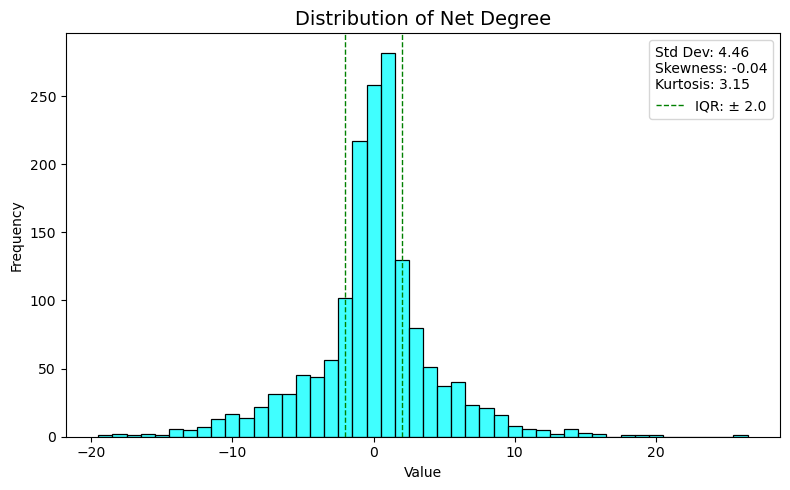

C:\Users\User\AppData\Local\Temp\ipykernel_30704\2935509419.py:23: DeprecationWarning: Please import `linregress` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  slope, intercept, r_value, p_value, std_err = stats.linregress(nd_npv_df['net_degree'], nd_npv_df['NPV_assumed'])


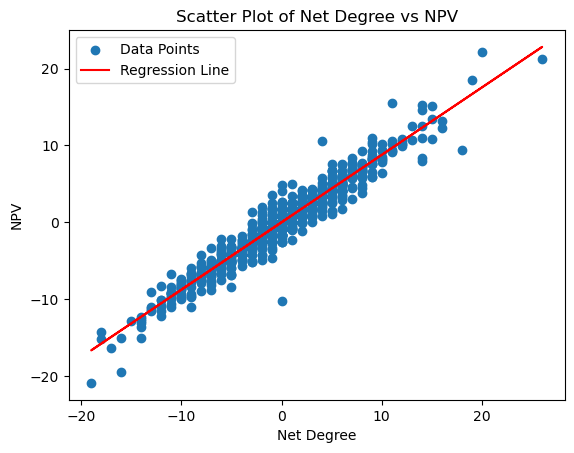

<Figure size 640x480 with 0 Axes>

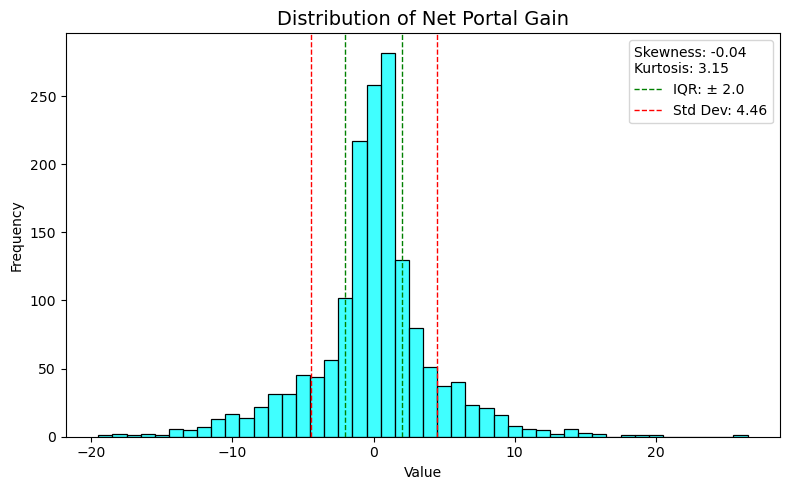

C:\Users\User\AppData\Local\Temp\ipykernel_30704\2779460043.py:25: DeprecationWarning: Please import `linregress` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  slope, intercept, r_value, p_value, std_err = stats.linregress(nd_npv_df['net_degree'], nd_npv_df['NPV_assumed'])


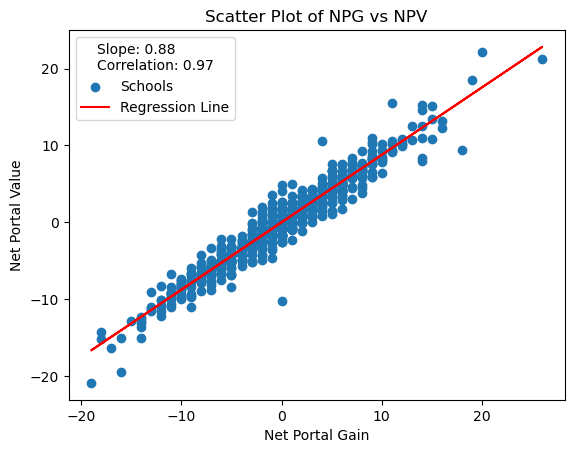

C:\Users\User\AppData\Local\Temp\ipykernel_30704\2779460043.py:36: DeprecationWarning: Please import `linregress` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  slope, intercept, r_value, p_value, std_err = stats.linregress(nd_npv_df['in_count'], nd_npv_df['out_count'])


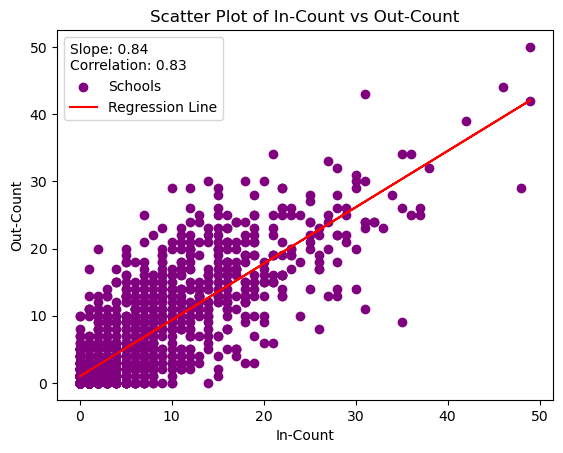

NameError: name 'npv_df' is not defined

<Figure size 640x480 with 0 Axes>

In [ ]:
# ND/NPV

# ND distribution
plt.figure(figsize=(8, 5))
sns.histplot(nd_npv_df['net_degree'], discrete=True, color='cyan')
plt.title('Distribution of Net Portal Gain', fontsize=14)
plt.xlabel('Value')
plt.ylabel('Frequency')
nd_std_dev = statistics.stdev(nd_npv_df['net_degree'])
q1 = np.percentile(nd_npv_df['net_degree'], 25)
q3 = np.percentile(nd_npv_df['net_degree'], 75)
iqr = q3 - q1
plt.axvline(q1, color='green', linestyle='dashed', linewidth=1, label=f'IQR: ± {iqr/2}')
plt.axvline(q3, color='green', linestyle='dashed', linewidth=1)
plt.axvline(nd_std_dev, color='red', linestyle='dashed', linewidth=1, label=f'Std Dev: {nd_std_dev:.2f}')
plt.axvline(-nd_std_dev, color='red', linestyle='dashed', linewidth=1)
leg = plt.legend(title=f"Skewness: {nd_npv_df['net_degree'].skew():.2f}\nKurtosis: {nd_npv_df['net_degree'].kurt():.2f}", )
leg._legend_box.align = "left"
plt.tight_layout()
plt.show()
plt.savefig(f'.\\imgs\\xfer\\graphs\\distribution_net_degree.png', dpi=250, bbox_inches='tight')

# ND/NPV SCATTER (with regression line)
plt.scatter(nd_npv_df['net_degree'], nd_npv_df['NPV_assumed'])
slope, intercept, r_value, p_value, std_err = stats.linregress(nd_npv_df['net_degree'], nd_npv_df['NPV_assumed'])
plt.plot(nd_npv_df['net_degree'], slope*nd_npv_df['net_degree'] + intercept, color='red')
plt.xlabel('Net Portal Gain')
plt.ylabel('Net Portal Value')
plt.title('Scatter Plot of NPG vs NPV')
plt.legend(['Schools', 'Regression Line'], title= f'Slope: {slope:.2f}\nCorrelation: {r_value:.2f}')
plt.show()
plt.savefig(f'.\\imgs\\xfer\\graphs\\scatter_net_degree_vs_npv.png', dpi=250, bbox_inches='tight')

# IN/OUT SCATTER (with regression line)
plt.scatter(nd_npv_df['in_count'], nd_npv_df['out_count'], color='purple')
slope, intercept, r_value, p_value, std_err = stats.linregress(nd_npv_df['in_count'], nd_npv_df['out_count'])
plt.plot(nd_npv_df['in_count'], slope*nd_npv_df['in_count'] + intercept, color='red')
plt.xlabel('In-Count')
plt.ylabel('Out-Count')
plt.title('Scatter Plot of In-Count vs Out-Count')
leg = plt.legend(['Schools', 'Regression Line'], title= f'Slope: {slope:.2f}\nCorrelation: {r_value:.2f}')
leg._legend_box.align = "left"
plt.show()
plt.savefig(f'.\\imgs\\xfer\\graphs\\scatter_in_vs_out_degree.png', dpi=250, bbox_inches='tight')

# AGG METRICS BY SCHOOL

# 1. Prepare your data
school_summary_npv = npv_df.groupby('school')['net_degree'].sum().reset_index().sort_values('net_degree', ascending=False)

# 2. Create explicit copies for Top and Bottom to avoid SettingWithCopy warnings
#    and manipulate their indices independently.

# --- Top 15 (Highest Net Degree) ---
df_top = school_summary_npv.head(15).copy()
df_top.reset_index(drop=True, inplace=True)  # Reset to 0, 1, 2...
df_top.index = df_top.index + 1             # Shift to 1, 2, 3...
df_top.index.name = 'Rank'                  # Set the header label

# --- Bottom 15 (Lowest Net Degree) ---
# Your logic was correct: tail(15) gets the bottom, sort_values(asc=True) puts the lowest first.
df_bottom = school_summary_npv.tail(15).sort_values('net_degree', ascending=True).copy()
df_bottom.reset_index(drop=True, inplace=True) # Reset to 0, 1, 2...
df_bottom.index = df_bottom.index + 1          # Shift to 1, 2, 3...
df_bottom.index.name = 'Rank'                  # Set the header label

# 3. Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6)) # Increased width slightly for readability
plt.suptitle('Aggregate Net Portal Gain by School', fontsize=16)

column_definitions = [ColumnDefinition(name='school', # name of the column to change
                                       title='School', # new title for the column
                                       textprops={"ha": "left"}),
                      ColumnDefinition(name='net_degree',
                                       title='Value',
                                       textprops={"ha": "right"}),
                      ColumnDefinition(name='Rank',
                                       textprops={'ha': 'right'})
                                      ]

# Create the tables
tab1 = Table(df_top, ax=axes[0], column_definitions=column_definitions)
tab2 = Table(df_bottom, ax=axes[1], column_definitions=column_definitions)
axes[0].set_title("Top", fontstyle='italic')
axes[1].set_title("Bottom", fontstyle='italic')

plt.tight_layout()
plt.show()

# AGG TEAM RATINGS BY SCHOOL FOR SAME YEARS

#teamratings_df['year'] = teamratings_df['season'].apply(lambda x: int(x.split('-')[0]))

In [60]:
# PROJECTING BIPARTITE RECRUITING NETWORK(S)

# function to calculate shared recruit volume for weights

def shared_recruit_volume(G, u, v):
    weight = 0
    # Find all hometowns (neighbors) that both schools share
    shared_hometowns = set(G[u]) & set(G[v])
    
    for h in shared_hometowns:
        # Get the weight (number of recruits) for School U -> Hometown
        w_u = G[u][h].get('weight', 1)
        # Get the weight (number of recruits) for School V -> Hometown
        w_v = G[v][h].get('weight', 1)
        
        # min to get overlap only
        weight += min(w_u, w_v)
        
    return weight

for file, B in recfiles.items():
    year = int(re.search(r'\d{4}', file).group())
    schools = {n for n, d in B.nodes(data=True) if d["bipartite"] == 0}
    hometowns = set(B) - schools
    # Collapse MultiGraph parallel edges into a single bipartite Graph where
    # each school-hometown edge has a 'weight' equal to the number of parallel edges
    G_bip_simple = nx.Graph()
    # copy nodes
    for n, d in B.nodes(data=True):
        G_bip_simple.add_node(n, **d)

    # accumulate weights (default: count parallel edges)
    edge_weights = {}
    for u, v, key, data in B.edges(keys=True, data=True):
        # determine which end is the school
        if u in schools and v not in schools:
            s, h = u, v
        elif v in schools and u not in schools:
            s, h = v, u
        else:
            # skip same-type edges (just in case)
            continue
        w = 1    
        edge_weights[(s, h)] = edge_weights.get((s, h), 0) + w

    # add aggregated edges to the simple bipartite graph
    for (s, h), w in edge_weights.items():
        G_bip_simple.add_edge(s, h, weight=w)

    # Now create a weighted projection of the school nodes
    projected = bipartite.generic_weighted_projected_graph(G_bip_simple, schools, weight_function=shared_recruit_volume)
    nx.write_graphml(projected, f'.\\data\\recruiting\\projections\\projected_{year}.graphml')

COURSE-REQUIRED ANALYSES

In [ ]:
# DEG DIST RECRUITING + PAGERANK

# --- individual years

for name, G in recfilesproj.items():
    year = name.split("_")[-1]
    for year in range(2002, 2026):
        degrees = [val for (node, val) in G.degree()]
        plt.figure(figsize=(8,4))
        sns.histplot(degrees, kde=False, color='red', discrete=True)
        plt.title(f"Recruiting Network Degree Distribution ({year})")
        plt.xlabel("Degree")
        plt.ylabel("Frequency")
        plt.xlim(left=0)
        plt.ylim(top=100)
        #plt.savefig(f".\\imgs\\rec\\graphs\\degdist\\rec_degree_distribution_{year}.png", dpi=250, bbox_inches='tight')
        plt.close()

# --- avg of all + log-log regression for power law

# find global max degree
max_degree_global = 0
for name, G in recfilesproj.items():
    degrees = [d for n, d in G.degree()]
    max_degree_global = max(max_degree_global, max(degrees))

# init array to sum up probabilities for each degree k
sum_probs = np.zeros(max_degree_global + 1)
num_years = 5
yearly_avg_degrees = []

for name, G in recfilesproj.items():
    degrees = [d for n, d in G.degree()]
    yearly_avg_degrees.append(np.mean(degrees))

    # calculate histogram for this specific year
    counts, bin_edges = np.histogram(degrees, bins=range(max_degree_global + 2))
    
    # normalize to get probabilities for this year
    probs = counts / sum(counts)
    
    # add to running total
    sum_probs += probs

# divide by number of years to get the mean probability per bin
avg_probs = sum_probs / num_years
degree_values = np.arange(len(avg_probs))

# fit power law with log-log regression and eliminate deg 0 schools
mask = (avg_probs > 0) & (degree_values > 0)
x_fit = degree_values[mask]
y_fit = avg_probs[mask]

# Perform linear regression on log-transformed data
# log(y) = -alpha * log(x) + c  =>  slope is -alpha
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(x_fit), np.log(y_fit))
alpha = -slope  # The decay exponent
power_law_const = np.exp(intercept)

# plotting
plt.figure(figsize=(10, 6))

# plot the bars
plt.bar(degree_values, avg_probs, color='skyblue', label='Observed Avg Distribution', alpha=0.7, width=1.0)

# plot the fit line
fit_y = power_law_const * (x_fit ** (-alpha))
plt.plot(x_fit, fit_y, 'r--', linewidth=2, label=f'Power Law Fit ($P(k) \propto k^{{-{alpha:.2f}}}$)')

# formatting
overall_avg_degree = np.mean(yearly_avg_degrees)
plt.title("Average Projected Recruiting Network Degree Distribution", fontsize=14)
plt.xlabel("Degree ($k$)", fontsize=12)
plt.ylabel("Average Probability ($P(k)$)", fontsize=12)
plt.xlim(0, 60) # Limit x-axis to see the head of the distribution clearly
plt.ylim(0, max(avg_probs) * 1.1)

# legend with stats
legend_text = f"Avg Degree: {overall_avg_degree:.2f}\nDecay Exponent ($\\alpha$): {alpha:.2f}\n$R^2$: {r_value**2:.2f}"
plt.legend(title=legend_text, title_fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.5)
#plt.savefig(f".\\imgs\\rec\\graphs\\degdist\\average_degree_distribution_rec.png", dpi=250, bbox_inches='tight')
plt.close()

# ========
# PAGERANK
# ========

pr_accumulator = {}

# Collect PR scores from each graph
for name, G in xferfiles.items():
    avg_pr_values = nx.pagerank(G)
    for node, pr in avg_pr_values.items():
        pr_accumulator.setdefault(node, []).append(pr)

# Compute average PR per school
avg_pr_values = np.array([np.mean(values) for values in pr_accumulator.values()])

# Safety check
if avg_pr_values.size == 0:
    raise RuntimeError("No pagerank scores available.")

# Build histogram of AVERAGE PR
n_bins = 60
max_pr = avg_pr_values.max()
bins = np.linspace(0.0, max_pr, n_bins + 1)

counts, _ = np.histogram(avg_pr_values, bins=bins)
probs = counts / counts.sum()

bin_centers = (bins[:-1] + bins[1:]) / 2

# Fit power law in log-log space (exclude zeroes)
mask = (probs > 0) & (bin_centers > 0)
x_fit = bin_centers[mask]
y_fit = probs[mask]

slope, intercept, r_value, p_value, std_err = stats.linregress(
    np.log(x_fit), np.log(y_fit)
)

alpha = -slope
power_law_const = np.exp(intercept)

# Evaluate fitted curve
fit_y = power_law_const * (x_fit ** (-alpha))

plt.figure(figsize=(10,6))
plt.bar(
    bin_centers,
    probs,
    width=np.diff(bins),
    color='mediumorchid',
    alpha=0.8,
    align='center',
    label='Average PageRank Distribution (per team)'
)

plt.plot(
    x_fit,
    fit_y,
    'r--',
    linewidth=2,
    label=f'Power Law Fit ($P(r) \\propto r^{{-{alpha:.2f}}}$)'
)

plt.title("Distribution of Average PageRank (Transfer Portal)", fontsize=14)
plt.xlabel("Average PageRank", fontsize=12)
plt.ylabel("Probability", fontsize=12)

plt.xlim(left=avg_pr_values.min() * 0.95)
plt.ylim(0, probs.max() * 1.1)

legend_text = f"Decay Exponent ($\\alpha$): {alpha:.2f}\n$R^2$: {r_value**2:.2f}"

leg = plt.legend(title=legend_text, title_fontsize=10)
leg.set_alignment("left")

plt.grid(axis='y', linestyle='--', alpha=0.5)
#plt.savefig(".\\imgs\\xfer\\graphs\\average_pagerank_distribution.png", dpi=250, bbox_inches='tight')
plt.close()

# single table with top 15 and bottom 15 PageRank scores

pr_df = pd.DataFrame({
    'school': list(pr_accumulator.keys()),
    'avg_pagerank': avg_pr_values  # keep numeric
})
pr_df = pr_df.sort_values('avg_pagerank', ascending=False)
pr_df_display = pr_df.copy()
pr_df_display['avg_pagerank'] = pr_df_display['avg_pagerank'].map(lambda x: f"{x:.4f}")

df_top = pr_df_display.head(15).copy()
df_top.reset_index(drop=True, inplace=True)  
df_top.index = df_top.index + 1             
df_top.index.name = 'Rank'                  

df_bottom = pr_df_display.tail(15).sort_values('avg_pagerank', ascending=True).copy()
df_bottom.reset_index(drop=True, inplace=True) 
df_bottom.index = df_bottom.index + 1          
df_bottom.index.name = 'Rank'                  

# 3. Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.suptitle('Average PageRank by School (D1 Only)', fontsize=16)

column_definitions = [ColumnDefinition(name='school',
                                       title='School',
                                       textprops={"ha": "left"}),
                      ColumnDefinition(name='avg_pagerank',
                                       title='Value',
                                       textprops={"ha": "right"}),
                      ColumnDefinition(name='Rank',
                                       textprops={'ha': 'right'})
                                      ]

# Create the tables
tab1 = Table(df_top, ax=axes[0], column_definitions=column_definitions)
tab2 = Table(df_bottom, ax=axes[1], column_definitions=column_definitions)
axes[0].set_title("Top", fontstyle='italic')
axes[1].set_title("Bottom", fontstyle='italic')

plt.tight_layout()
#plt.savefig(f'.\\imgs\\xfer\\graphs\\pagerank_top_bottom.png', dpi=250, bbox_inches='tight')
plt.close()

# ========
# DIRECTED BETWEENNESS (D1-only)
# ========

# build D1 set from latest classification info
latest_year = comprehensive_metrics_df['year'].max()
class_map = comprehensive_metrics_df.loc[comprehensive_metrics_df['year'] == latest_year, ['school', 'classification']].drop_duplicates()
class_map['school_lower'] = class_map['school'].str.lower().str.strip()
class_map['classification'] = class_map['classification'].astype(str).str.lower().str.strip()
d1_set = set(class_map.loc[class_map['classification'].isin(['fbs', 'fcs']), 'school_lower'])

bc_accumulator = {}

# Compute directed betweenness centrality for each year's graph, but only accumulate D1 nodes
for name, G in xferfiles.items():
    bc_values = nx.betweenness_centrality(G, normalized=True)
    for node, bc in bc_values.items():
        node_norm = str(node).lower().strip()
        if node_norm in d1_set:
            bc_accumulator.setdefault(node, []).append(bc)

# Average BC per school (D1-only)
avg_bc_values = np.array([np.mean(values) for values in bc_accumulator.values()])

if avg_bc_values.size == 0:
    raise RuntimeError("No betweenness centrality scores available for D1 schools.")

# Build histogram
n_bins = 60
max_bc = avg_bc_values.max()
bins = np.linspace(0.0, max_bc, n_bins + 1)

counts, _ = np.histogram(avg_bc_values, bins=bins)
probs = counts / counts.sum()
bin_centers = (bins[:-1] + bins[1:]) / 2

# Power-law fit (in log-log) -- exclude zeros
mask = (probs > 0) & (bin_centers > 0)
x_fit = bin_centers[mask]
y_fit = probs[mask]

slope, intercept, r_value, p_value, std_err = stats.linregress(
    np.log(x_fit), np.log(y_fit)
)

alpha = -slope
power_law_const = np.exp(intercept)
fit_y = power_law_const * (x_fit ** (-alpha))

plt.figure(figsize=(10, 6))
plt.bar(
    bin_centers, probs,
    width=np.diff(bins),
    color='mediumorchid',
    alpha=0.8,
    label='Avg Directed Betweenness Distribution (D1 only)'
)
plt.plot(
    x_fit, fit_y,
    'r--', linewidth=2,
    label=f'Power Law Fit ($P(bc) \\propto bc^{{-{alpha:.2f}}}$)'
)

plt.title("Distribution of Average Directed Betweenness Centrality (D1)", fontsize=14)
plt.xlabel("Average BC", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

legend_text = f"Decay Exponent (α): {alpha:.2f}\nR²: {r_value**2:.2f}"
leg = plt.legend(title=legend_text, title_fontsize=10)
leg.set_alignment("left")

plt.tight_layout()
#plt.savefig(f'.\\imgs\\xfer\\graphs\\betweenness_distribution_d1.png', dpi=250, bbox_inches='tight')
plt.show()

# -------------------------
# Top / Bottom 15 Table (D1-only)
# -------------------------
bc_df = pd.DataFrame({
    'school': list(bc_accumulator.keys()),
    'avg_bc': avg_bc_values
})

if bc_df.empty:
    raise RuntimeError("No D1 betweenness centrality results to display.")

# sort and format for display
bc_df = bc_df.sort_values('avg_bc', ascending=False)

bc_df_disp = bc_df.copy()
bc_df_disp['avg_bc'] = bc_df_disp['avg_bc'].map(lambda x: f"{x:.5f}")

n_top = min(15, len(bc_df_disp))
n_bottom = min(15, len(bc_df_disp))

df_top = bc_df_disp.head(n_top).copy()
df_top.index = np.arange(1, n_top + 1)
df_top.index.name = 'Rank'

df_bottom = bc_df_disp.tail(n_bottom).sort_values('avg_bc').copy()
df_bottom.index = np.arange(1, n_bottom + 1)
df_bottom.index.name = 'Rank'

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.suptitle("Average Directed Betweenness Centrality (Top / Bottom D1 Schools)", fontsize=16)

col_defs = [
    ColumnDefinition(name='school', title='School', textprops={'ha': 'left'}),
    ColumnDefinition(name='avg_bc', title='Value', textprops={'ha': 'right'}),
    ColumnDefinition(name='Rank', textprops={'ha': 'right'})
]

tab1 = Table(df_top, ax=axes[0], column_definitions=col_defs)
tab2 = Table(df_bottom, ax=axes[1], column_definitions=col_defs)

axes[0].set_title("Top", fontstyle='italic')
axes[1].set_title("Bottom", fontstyle='italic')

plt.tight_layout()
#plt.savefig(f'.\\imgs\\xfer\\graphs\\betweenness_top_bottom_d1.png', dpi=250, bbox_inches='tight')
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_4324\4187147262.py:42: DeprecationWarning: Please import `linregress` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  slope, intercept, r_value, p_value, std_err = stats.linregress(


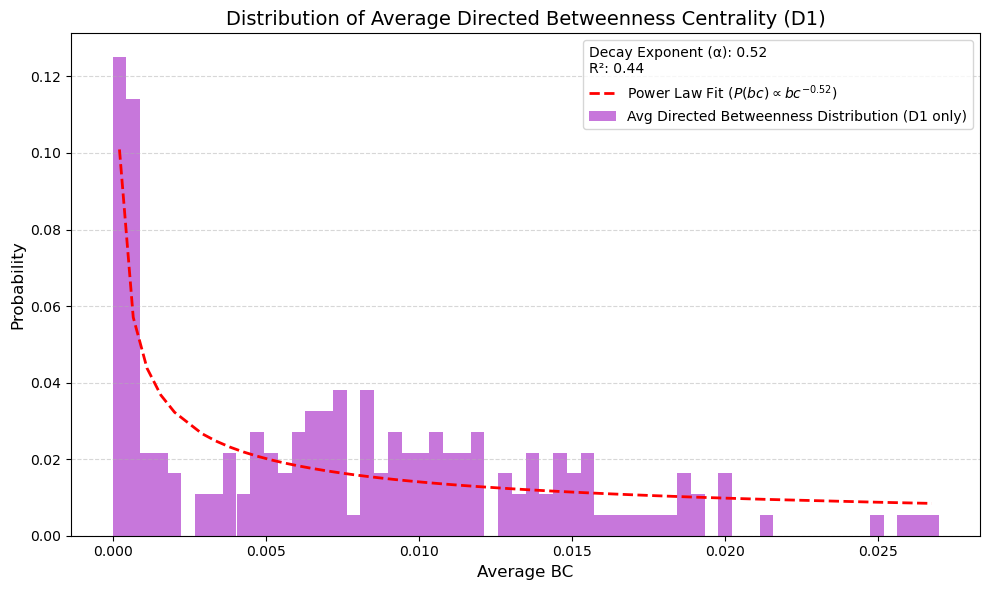

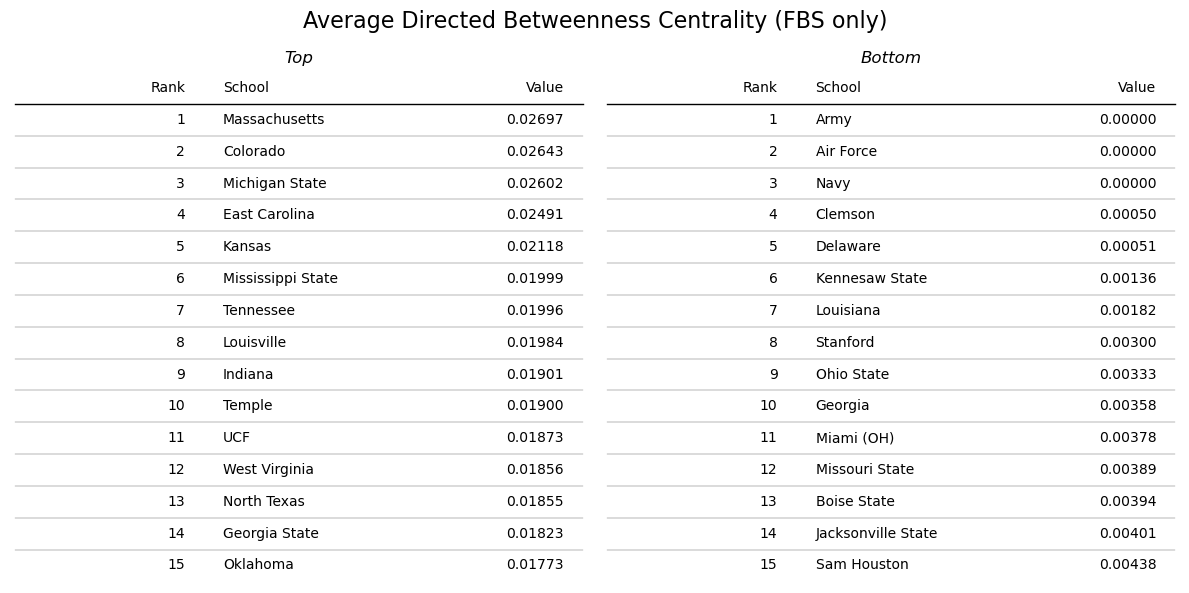

In [ ]:
# DIRECTED BETWEENNESS (D1-only)
# ========

# build D1 set from latest classification info
latest_year = comprehensive_metrics_df['year'].max()
class_map = comprehensive_metrics_df.loc[comprehensive_metrics_df['year'] == latest_year, ['school', 'classification']].drop_duplicates()
class_map['school_lower'] = class_map['school'].str.lower().str.strip()
class_map['classification'] = class_map['classification'].astype(str).str.lower().str.strip()
d1_set = set(class_map.loc[class_map['classification'].isin(['fbs', 'fcs']), 'school_lower'])

bc_accumulator = {}

# Compute directed betweenness centrality for each year's graph, but only accumulate D1 nodes
for name, G in xferfiles.items():
    bc_values = nx.betweenness_centrality(G, normalized=True)
    for node, bc in bc_values.items():
        node_norm = str(node).lower().strip()
        if node_norm in d1_set:
            bc_accumulator.setdefault(node, []).append(bc)

# Average BC per school (D1-only)
avg_bc_values = np.array([np.mean(values) for values in bc_accumulator.values()])

if avg_bc_values.size == 0:
    raise RuntimeError("No betweenness centrality scores available for D1 schools.")

# Build histogram
n_bins = 60
max_bc = avg_bc_values.max()
bins = np.linspace(0.0, max_bc, n_bins + 1)

counts, _ = np.histogram(avg_bc_values, bins=bins)
probs = counts / counts.sum()
bin_centers = (bins[:-1] + bins[1:]) / 2

# Power-law fit (in log-log) -- exclude zeros
mask = (probs > 0) & (bin_centers > 0)
x_fit = bin_centers[mask]
y_fit = probs[mask]

slope, intercept, r_value, p_value, std_err = stats.linregress(
    np.log(x_fit), np.log(y_fit)
)

alpha = -slope
power_law_const = np.exp(intercept)
fit_y = power_law_const * (x_fit ** (-alpha))

plt.figure(figsize=(10, 6))
plt.bar(
    bin_centers, probs,
    width=np.diff(bins),
    color='mediumorchid',
    alpha=0.8,
    label='Avg Directed Betweenness Distribution (D1 only)'
)
plt.plot(
    x_fit, fit_y,
    'r--', linewidth=2,
    label=f'Power Law Fit ($P(bc) \\propto bc^{{-{alpha:.2f}}}$)'
)

plt.title("Distribution of Average Directed Betweenness Centrality (D1)", fontsize=14)
plt.xlabel("Average BC", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

legend_text = f"Decay Exponent (α): {alpha:.2f}\nR²: {r_value**2:.2f}"
leg = plt.legend(title=legend_text, title_fontsize=10)
leg.set_alignment("left")

plt.tight_layout()
#plt.savefig(f'.\\imgs\\xfer\\graphs\\betweenness_distribution_d1.png', dpi=250, bbox_inches='tight')
plt.show()

# -------------------------
# Top / Bottom 15 Table (FBS-only)
# -------------------------
# build FBS set from classification map (already normalized)
fbs_set = set(class_map.loc[class_map['classification'] == 'fbs', 'school_lower'])

# build dataframe from bc_accumulator but include only FBS schools
fbs_items = [
    (node, np.mean(values))
    for node, values in bc_accumulator.items()
    if str(node).lower().strip() in fbs_set
]

if len(fbs_items) == 0:
    raise RuntimeError("No betweenness centrality scores available for FBS schools.")

bc_df = pd.DataFrame(fbs_items, columns=['school', 'avg_bc'])

# sort and format for display
bc_df = bc_df.sort_values('avg_bc', ascending=False)

bc_df_disp = bc_df.copy()
bc_df_disp['avg_bc'] = bc_df_disp['avg_bc'].map(lambda x: f"{x:.5f}")

n_top = min(15, len(bc_df_disp))
n_bottom = min(15, len(bc_df_disp))

df_top = bc_df_disp.head(n_top).copy()
df_top.index = np.arange(1, n_top + 1)
df_top.index.name = 'Rank'

df_bottom = bc_df_disp.tail(n_bottom).sort_values('avg_bc').copy()
df_bottom.index = np.arange(1, n_bottom + 1)
df_bottom.index.name = 'Rank'

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.suptitle("Average Directed Betweenness Centrality (FBS only)", fontsize=16)

col_defs = [
    ColumnDefinition(name='school', title='School', textprops={'ha': 'left'}),
    ColumnDefinition(name='avg_bc', title='Value', textprops={'ha': 'right'}),
    ColumnDefinition(name='Rank', textprops={'ha': 'right'})
]

tab1 = Table(df_top, ax=axes[0], column_definitions=col_defs)
tab2 = Table(df_bottom, ax=axes[1], column_definitions=col_defs)

axes[0].set_title("Top", fontstyle='italic')
axes[1].set_title("Bottom", fontstyle='italic')

plt.tight_layout()
#plt.savefig(f'.\\imgs\\xfer\\graphs\\betweenness_top_bottom_fbs.png', dpi=250, bbox_inches='tight')
plt.show()


RECRUITING ANALYSIS

PORTAL ANALYSIS

<>:69: SyntaxWarning: invalid escape sequence '\p'
<>:69: SyntaxWarning: invalid escape sequence '\p'
C:\Users\User\AppData\Local\Temp\ipykernel_30704\526122327.py:69: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(x_fit, fit_y, 'r--', linewidth=2, label=f'Power Law Fit ($P(k) \propto k^{{-{alpha:.2f}}}$)')
C:\Users\User\AppData\Local\Temp\ipykernel_30704\526122327.py:57: DeprecationWarning: Please import `linregress` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(x_fit), np.log(y_fit))


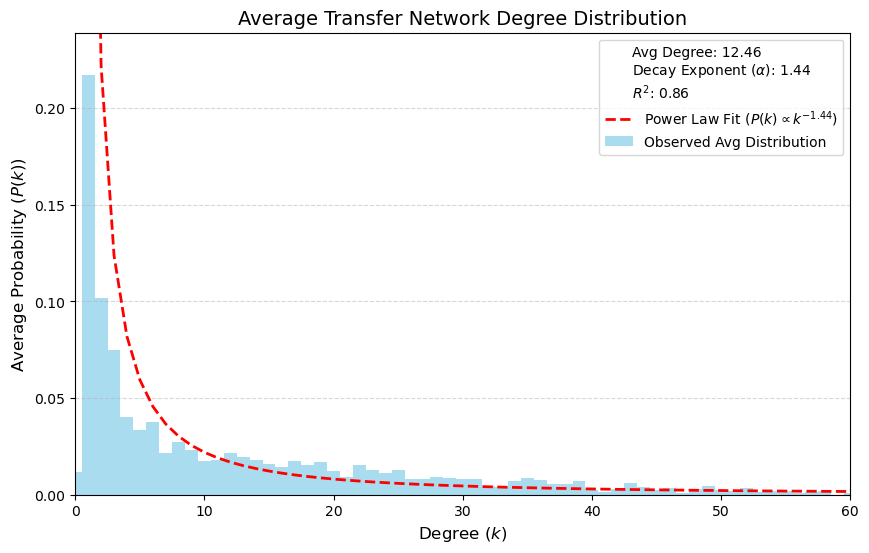

In [ ]:
# --- DISTRIBUTIONS

# DEGREE

# --- individual years

for name, G in xferfiles.items():
    year = name.split("_")[-1]
    degrees = [val for (node, val) in G.degree()]
    plt.figure(figsize=(8,4))
    sns.histplot(degrees, kde=False, color='red', discrete=True)
    plt.title(f"Transfer Network Degree Distribution ({year})")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.xlim(left=0)
    plt.ylim(top=100)
    #plt.savefig(f".\\imgs\\graphs\\degdist\\degree_distribution_{year}.png", dpi=250, bbox_inches='tight')
    plt.close()

# --- avg of all + log-log regression for power law

# find global max degree
max_degree_global = 0
for name, G in xferfiles.items():
    degrees = [d for n, d in G.degree()]
    max_degree_global = max(max_degree_global, max(degrees))

# init array to sum up probabilities for each degree k
sum_probs = np.zeros(max_degree_global + 1)
num_years = 5
yearly_avg_degrees = []

for name, G in xferfiles.items():
    degrees = [d for n, d in G.degree()]
    yearly_avg_degrees.append(np.mean(degrees))

    # calculate histogram for this specific year
    counts, bin_edges = np.histogram(degrees, bins=range(max_degree_global + 2))
    
    # normalize to get probabilities for this year
    probs = counts / sum(counts)
    
    # add to running total
    sum_probs += probs

# divide by number of years to get the mean probability per bin
avg_probs = sum_probs / num_years
degree_values = np.arange(len(avg_probs))

# fit power law with log-log regression and eliminate deg 0 schools
mask = (avg_probs > 0) & (degree_values > 0)
x_fit = degree_values[mask]
y_fit = avg_probs[mask]

# Perform linear regression on log-transformed data
# log(y) = -alpha * log(x) + c  =>  slope is -alpha
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(x_fit), np.log(y_fit))
alpha = -slope  # The decay exponent
power_law_const = np.exp(intercept)

# plotting
plt.figure(figsize=(10, 6))

# plot the bars
plt.bar(degree_values, avg_probs, color='skyblue', label='Observed Avg Distribution', alpha=0.7, width=1.0)

# plot the fit line
fit_y = power_law_const * (x_fit ** (-alpha))
plt.plot(x_fit, fit_y, 'r--', linewidth=2, label=f'Power Law Fit ($P(k) \propto k^{{-{alpha:.2f}}}$)')

# formatting
overall_avg_degree = np.mean(yearly_avg_degrees)
plt.title("Average Transfer Network Degree Distribution", fontsize=14)
plt.xlabel("Degree ($k$)", fontsize=12)
plt.ylabel("Average Probability ($P(k)$)", fontsize=12)
plt.xlim(0, 60) # Limit x-axis to see the head of the distribution clearly
plt.ylim(0, max(avg_probs) * 1.1)

# legend with stats
legend_text = f"Avg Degree: {overall_avg_degree:.2f}\nDecay Exponent ($\\alpha$): {alpha:.2f}\n$R^2$: {r_value**2:.2f}"
plt.legend(title=legend_text, title_fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.5)
#plt.savefig(f".\\imgs\\graphs\\degdist\\average_degree_distribution.png", dpi=250, bbox_inches='tight')
plt.show()